# 04 - Sea Glider - Calculation of physical variables
### This is done after gridding

*buoyancy, N^2, MLDs, buoyancy gradient*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
import pathlib
from pathlib import Path
import os
import netCDF4
from netCDF4 import Dataset as nc
import glob
from glob import glob
import glidertools as gt
import gsw
import csv
import sys
import array

import warnings
warnings.simplefilter("ignore", UserWarning)
def write_with_byte_inversion(f, tab):
    tab2write = array.array('f', tab.T.flatten())
    if sys.byteorder == 'little':
        tab2write.byteswap()
    f.write(tab2write)

dtype=np.float32

### Open gridded dataset

In [2]:
ds = xr.open_dataset(r"Data/03_ds_grid_15.nc")

In [3]:
ds

<xarray.Dataset>
Dimensions:                   (ctd_depth: 2001, distance: 207)
Coordinates:
  * ctd_depth                 (ctd_depth) float64 0.0 0.5 1.0 ... 999.5 1e+03
    dives                     (distance) float64 ...
    latitude                  (distance) float64 ...
    longitude                 (distance) float64 ...
    ATD                       (distance) float64 ...
  * distance                  (distance) float64 0.0 1.5 3.0 ... 307.5 309.0
Data variables:
    temperature_qc            (ctd_depth, distance) float64 ...
    salinity_qc               (ctd_depth, distance) float64 ...
    conservative_temperature  (ctd_depth, distance) float64 ...
    absolute_salinity         (ctd_depth, distance) float64 ...
    sigma0                    (ctd_depth, distance) float64 ...
    ctd_pressure              (ctd_depth, distance) float64 ...
Attributes:
    title:        Seaglider section gridded along water-relative distance (1....
    source:       Derived from 03_ds_vertgrid_dives.nc via xarray.interp alon...
    description:  Depth–distance section created from per-dive, 0.5 m vertica...

### Buoyancy

In [4]:
g = 9.81
rho0 = 1025.0

rho_pot = ds['sigma0'] + 1000.0  # potentiell densitet (p_ref = 0 dbar)
b = g * (1.0 - (rho_pot / rho0))

b.attrs.update({
    'long_name': 'buoyancy (from potential density)',
    'units': 'm s-2',
    'definition': 'b = g * (1 - rho_pot/rho0); rho_pot = sigma0 + 1000; rho0 constant'
})

ds['b'] = b

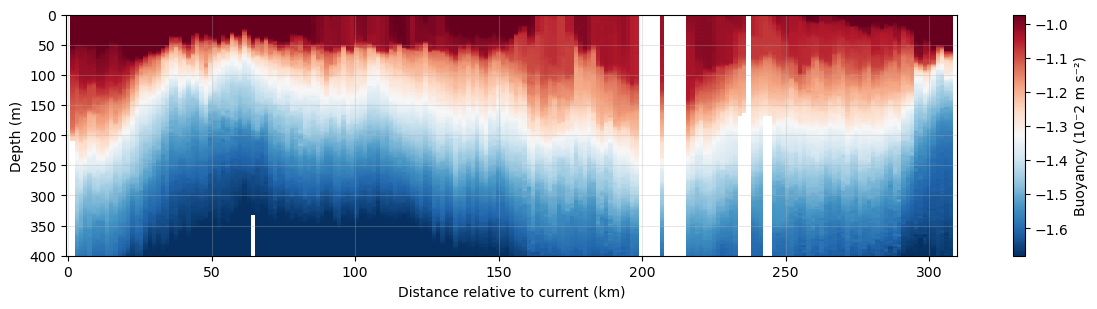

In [37]:
zmin, zmax = 0.0, 400 

# Begränsa data till valt djup för färgskalan
B = ds['b'] * 1e2
B_sub = B.sel(ctd_depth=slice(zmin, zmax))
vmin = float(np.nanpercentile(B_sub, 5))
vmax = float(np.nanpercentile(B_sub, 95))

fig, ax = plt.subplots(figsize=(12, 3.2))
im = ax.pcolormesh(
    ds['distance'],      # x (km)
    ds['ctd_depth'],             # y (m)
    B,                             # hela fältet går bra
    shading='auto',
    cmap='RdBu_r',
    vmin=vmin, vmax=vmax,
    rasterized=True
)
ax.set_ylim(zmax, zmin)            # visa bara 0–450 m och invert samtidigt
#ax.invert_yaxis()
ax.set_xlabel('Distance relative to current (km)')
ax.set_ylabel('Depth (m)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Buoyancy (10⁻2 m s⁻²)')
ax.grid(True, alpha=0.3)
plt.tight_layout()

### Mixed Layer Depth (MLD)

In [6]:
# 1) Referens: potentiell densitet vid 10 m (ta närmaste gridpunkt)
sigma0_10m = ds['sigma0'].sel(ctd_depth=10.0, method='nearest')   # dims: distance

# 2) Tröskel = sigma0(10 m) + 0.03, broadcast till (ctd_depth × distance)
threshold = (sigma0_10m + 0.03).broadcast_like(ds['sigma0'])

# 3) Första djup där sigma0 >= threshold
cond = ds['sigma0'] >= threshold                                  # bool, (ctd_depth × distance)
has_cross = cond.any('ctd_depth')                                  # True om tröskel passeras i kolumnen
mld_raw = cond.idxmax('ctd_depth')                                 # ger första ctd_depth där cond blir True

# 4) Kolumner utan korsning -> NaN
ds['MLD'] = xr.where(has_cross, mld_raw, np.nan)
ds['MLD'].attrs.update({
    'long_name': 'Mixed Layer Depth (density threshold)',
    'units': 'm',
    'definition': 'Depth where sigma0 >= sigma0(z=10 m) + 0.03 kg m-3 (first crossing)'
})

print(ds['MLD'])

<xarray.DataArray 'MLD' (distance: 207)>
array([  nan,  32.5,  28. ,  15. ,  13.5,  22.5,  21.5,  58. ,  49.5,
        31.5,  38.5,  42.5,  40. ,  44.5,  40. ,  30. ,  25.5,  59.5,
        49. ,  48. ,  52. ,  49.5,  46. ,  25.5,  21. ,  23. ,  22. ,
        30. ,  16.5,  14. ,  13.5,  12. ,  12. ,  16.5,  17. ,  20.5,
        22.5,  22. ,  21.5,  25. ,  24.5,  19. ,  17. ,  17. ,  28.5,
        28. ,  21.5,  17.5,  15. ,  12. ,  20.5,  35.5,  26.5,  27. ,
        28.5,  39. ,  44. ,  49. ,  49. ,  48. ,  59.5,  60.5,  54.5,
        54.5,  51.5,  59. ,  61. ,  43.5,  44. ,  45. ,  47.5,  51. ,
        60. ,  59.5,  61. ,  44.5,  46.5,  47. ,  54. ,  55.5,  55.5,
        47.5,  47.5,  44. ,  52. ,  57. ,  56.5,  56.5,  34. ,  34. ,
        22.5,  16.5,  19.5,  26. ,  28. ,  31.5,  34.5,  35. ,  19. ,
        16. ,  26. ,  26. ,  36.5,  32.5,  28.5,  13.5,  16. ,  31.5,
        32.5,  35.5,  82.5, 104. ,  97. ,  89.5, 101.5, 101. ,  44. ,
        36.5,  37.5,  51.5,  61. ,  57.5,  52.5, 

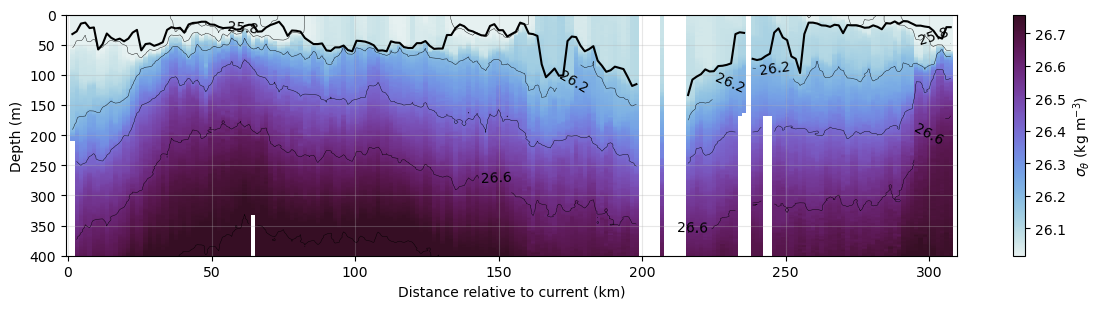

In [42]:
zmin, zmax = 0.0, 400.0

beginning = 25  # Beginning value
ending = 27.0    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

S_sub = ds['sigma0'].sel(ctd_depth=slice(zmin, zmax))
vmin = float(np.nanpercentile(S_sub, 5))
vmax = float(np.nanpercentile(S_sub, 95))

fig, ax = plt.subplots(figsize=(12, 3.2))

im = ax.pcolormesh(ds['distance'], ds['ctd_depth'], ds['sigma0'], shading='auto', cmap='cmo.dense', vmin=vmin, vmax=vmax, rasterized=True)
ax.plot(ds['distance'], ds['MLD'], 'k-', lw=1.5)   # MLD

cs = ax.contour(ds.distance, ds.ctd_depth, ds.sigma0, levels=levels, colors='k', linewidths=0.3)
ax.clabel(cs, levels=levels[::2], inline=True, fmt="%.1f", fontsize=10)

ax.set_ylim(zmax, zmin)  
#ax.invert_yaxis()
ax.set_xlabel('Distance relative to current (km)')
ax.set_ylabel('Depth (m)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$\sigma_\theta$ (kg m$^{-3}$)')
ax.grid(True, alpha=0.3)
plt.tight_layout()

### N^2 with gsw

In [9]:
# mid-level djup (bara för koordinaten)
z = ds['ctd_depth'].values
z_mid = 0.5 * (z[1:] + z[:-1])

def nsq_core_segmented(SA, CT, p, lat):
    SA = np.asarray(SA, float)
    CT = np.asarray(CT, float)
    p  = np.asarray(p,  float)
    n  = SA.size
    out = np.full(n-1, np.nan)

    ok = np.isfinite(SA) & np.isfinite(CT) & np.isfinite(p)
    idx = np.where(ok)[0]
    if idx.size < 2:
        return out

    # hitta sammanhängande block av giltiga nivåer
    splits = np.where(np.diff(idx) > 1)[0] + 1
    runs = np.split(idx, splits)  # lista av index-arrayer

    for run in runs:
        if run.size < 2:
            continue
        # beräkna N2 i detta sammanhängande block
        N2_i, p_mid = gsw.Nsquared(SA[run], CT[run], p[run], float(lat))
        # skriv tillbaka på rätt mid-positioner: mellan run[k] och run[k+1] -> index run[:-1]
        out[run[:-1]] = N2_i

    return out

# vektorisera över 'distance'; kärndim är 'ctd_depth'
N2 = xr.apply_ufunc(
    nsq_core_segmented,
    ds['absolute_salinity'],          # (ctd_depth, distance)
    ds['conservative_temperature'],
    ds['ctd_pressure'],
    ds['latitude'],                   # (distance,) eller skalar broadcastas
    input_core_dims=[['ctd_depth'], ['ctd_depth'], ['ctd_depth'], []],
    output_core_dims=[['ctd_depth_mid']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)

In [10]:
N2 = N2.assign_coords(ctd_depth_mid=('ctd_depth_mid', z_mid))
N2.name = 'N2'
N2.attrs.update({
    'long_name': 'Brunt–Väisälä frequency squared',
    'units': 's^-2',
    'method': 'TEOS-10 gsw.Nsquared on contiguous valid segments (mid-levels)'
})

ds['N2'] = N2
print(ds['N2'])

<xarray.DataArray 'N2' (distance: 207, ctd_depth_mid: 2000)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [            nan,  0.00000000e+00, -5.64751155e-06, ...,
                    nan,             nan,             nan],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.15470346e-05, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00,  3.87974070e-06, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
    dives          (distance) float64 nan 4.785 5.762 6.745 ... 127.6 128.1 nan
    latitude       (distance) float64 nan -34.49 -34.47 ... -35.42 -35.41 nan
    longitu

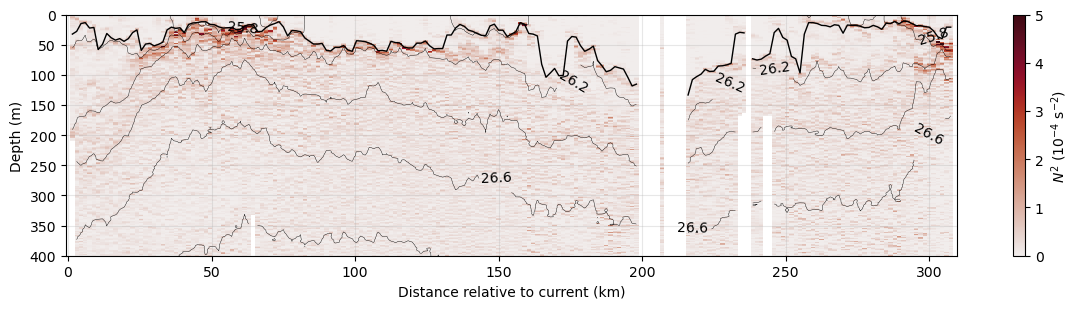

In [40]:
zmin, zmax = 0.0, 400.0

beginning = 25  # Beginning value
ending = 27.0    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# N2 på mid-levels, skala till "per 1e-4"
C = (ds['N2'].transpose('ctd_depth_mid','distance')) * 1e4   # ← bara *1e4

# färgskala från valt djupintervall
C_sub = C.sel(ctd_depth_mid=slice(zmin, zmax))
#vmin = float(np.nanpercentile(C_sub, 5))
#vmax = float(np.nanpercentile(C_sub, 95))

fig, ax = plt.subplots(figsize=(12, 3.2))

im = ax.pcolormesh(ds['distance'], ds['N2']['ctd_depth_mid'], C, shading='auto', cmap=cmo.amp, vmin=0, vmax=5, rasterized=True)
ax.plot(ds['distance'], ds['MLD'], 'k-', lw=1) # MLD

cs = ax.contour(ds.distance, ds.ctd_depth, ds.sigma0, levels=levels, colors='k', linewidths=0.3)
ax.clabel(cs, levels=levels[::2], inline=True, fmt="%.1f", fontsize=10)

ax.set_ylim(zmax, zmin)
ax.set_xlabel('Distance relative to current (km)')
ax.set_ylabel('Depth (m)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$N^2\ (10^{-4}\ \mathrm{s^{-2}})$') 
ax.grid(True, alpha=0.3)
plt.tight_layout()